In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shapefile
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

import folium
from folium.plugins import MarkerCluster

In [2]:
# Geocoding

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(user_agent="vv")

def do_geocode(g):
    try:
        loc = geolocator.geocode(g)
        print(loc.address)
        return loc
    except GeocoderTimedOut:
        return do_geocode(g)

In [3]:
# Timestamp
from datetime import date

today = date.today() # date object
# Format
time_stamp = today.strftime("%m-%d-%Y")

# Loading the data

In [4]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1rLAZH7wN9DkigkFD070gy5YbEPr-RPQaqPvnePrh31E' +
                   '/export?gid=30186846&format=csv')
df.head()

,CaseCode,Age,AgeGroup,Sex,DateRepConf,DateRecover,DateDied,RemovalType,DateRepRem,Admitted,RegionRes,ProvCityRes
0,C404174,38.0,35 to 39,Female,1/30/2020,8/2/2020,NaN,Recovered,2/10/2020,NaN,Negros Oriental,Dumaguete City (Capital)
1,C462688,44.0,40 to 44,Male,2/3/2020,NaN,1/2/2020,Died,2/2/2020,NaN,Negros Oriental,Dumaguete City (Capital)
2,C387710,60.0,60 to 64,Female,2/5/2020,1/31/2020,NaN,Recovered,2/10/2020,Yes,Bohol,Panglao
3,C377460,48.0,45 to 49,Male,3/6/2020,3/19/2020,NaN,Recovered,3/27/2020,Yes,NCR,Taguig City
4,C498051,62.0,60 to 64,Male,3/6/2020,NaN,11/3/2020,Died,3/12/2020,Yes,Rizal,Cainta


In [5]:
len(df)

5453

total cases in the country

# Cleaning

### Changing Region names to match the shapefiles's region names

In [6]:
df.RegionRes.replace(to_replace ="Cotabato City (not a province)", value ="Maguindanao", inplace=True) 
df.RegionRes.replace(to_replace ="NCR", value ="Metropolitan Manila", inplace=True) 
df.RegionRes.replace(to_replace ="Cotabato (North Cotabato)", value ="North Cotabato", inplace=True) 
df.RegionRes.replace(to_replace ="Samar (Western Samar)", value ="Samar", inplace=True) 

### Removing the hour in the time

In [7]:
def remove_hr(date):
    # not null
    if pd.notnull(date):
    # Makes variable into a text
        txt = str(date)
        return pd.to_datetime(txt.split()[0])
    else:
        date

In [8]:
df.DateRepConf = df.DateRepConf.apply(remove_hr)
df.DateRepRem = df.DateRepRem.apply(remove_hr)
df.DateRecover = df.DateRecover.apply(remove_hr)
df.DateDied = df.DateDied.apply(remove_hr)


df.head()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(df)

,CaseCode,Age,AgeGroup,Sex,DateRepConf,DateRecover,DateDied,RemovalType,DateRepRem,Admitted,RegionRes,ProvCityRes
0,C404174,38.0,35 to 39,Female,2020-01-30,2020-08-02,NaT,Recovered,2020-02-10,NaN,Negros Oriental,Dumaguete City (Capital)
1,C462688,44.0,40 to 44,Male,2020-02-03,NaT,2020-01-02,Died,2020-02-02,NaN,Negros Oriental,Dumaguete City (Capital)
2,C387710,60.0,60 to 64,Female,2020-02-05,2020-01-31,NaT,Recovered,2020-02-10,Yes,Bohol,Panglao
3,C377460,48.0,45 to 49,Male,2020-03-06,2020-03-19,NaT,Recovered,2020-03-27,Yes,Metropolitan Manila,Taguig City
4,C498051,62.0,60 to 64,Male,2020-03-06,NaT,2020-11-03,Died,2020-03-12,Yes,Rizal,Cainta


### Cleaning date of death and recoveries

### Errors

DateRecover


2020-08-02

In [9]:
def change_date(date):
    # not null
    if pd.notnull(date):
    # Makes variable into a text
        return str(date)
    else:
        date

In [10]:
# Changing to string
ls_dates_recover = np.array(df.DateRecover.apply(change_date))

# Errorneous values
ls_dates_recover[ls_dates_recover=='2020-08-02 00:00:00']='2020-02-08 00:00:00'

# Updating by making each entry into datetime
df.DateRecover = [pd.to_datetime(i) for i in ls_dates_recover]

### Errors

2020-12-03

2020-11-03

2020-01-02	

In [11]:
df.DateDied.unique()

ls_dates_died = np.array(df.DateDied.apply(change_date))
ls_dates_died[ls_dates_died=='2020-12-03 00:00:00']='2020-03-12 00:00:00'
ls_dates_died[ls_dates_died=='2020-11-03 00:00:00']='2020-03-11 00:00:00'
ls_dates_died[ls_dates_died=='2020-01-02 00:00:00']='2020-02-01 00:00:00'
df.DateDied = [pd.to_datetime(i) for i in ls_dates_died]

# Time series

### Number of cases per day

In [12]:
df_number_of_cases = pd.DataFrame(df.DateRepConf.value_counts())
df_number_of_cases.columns = ['new_cases']
df_number_of_cases.sort_index(inplace=True)
df_number_of_cases['total_cases'] = np.cumsum(df_number_of_cases.new_cases)
df_number_of_cases.head()

,new_cases,total_cases
2020-01-30,1,1
2020-02-03,1,2
2020-02-05,1,3
2020-03-06,2,5
2020-03-07,1,6


### Plot

<IPython.core.display.Javascript object>


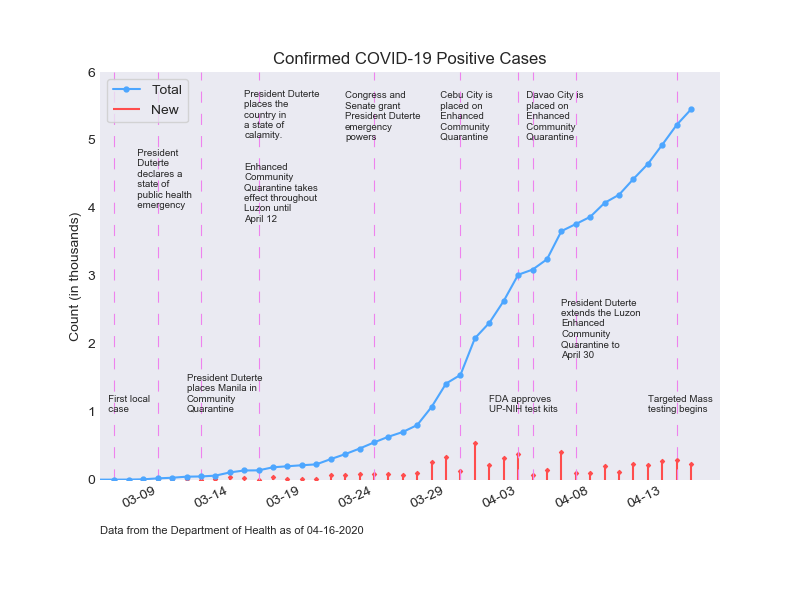

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
plt.title('Confirmed COVID-19 Positive Cases')

# Story
ax.axvline(pd.to_datetime('2020-03-06'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-05'), 1, '   First local\n   case', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-9'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-07'), 4, '   President\n   Duterte\n   declares a\n   state of\n   public health\n   emergency', fontsize=7)

#ax.axvline(pd.to_datetime('2020-03-10'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
#ax.text(pd.to_datetime('2020-03-08'), 1.7, '   Classes in all\n   levels are\n   suspended from\n   March 10-14', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-12'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-11'), 1, 'President Duterte\nplaces Manila in\nCommunity\nQuarantine', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-16'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-15'), 3.8, 'President Duterte\nplaces the\ncountry in\na state of\ncalamity.\n\n\nEnhanced\nCommunity\nQuarantine takes\neffect throughout\nLuzon until\nApril 12', fontsize=7)

#ax.axvline(pd.to_datetime('2020-03-17'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
#ax.text(pd.to_datetime('2020-03-16'), 2.2, '  Airline companies\n  start cancellations\n  of domestic flights', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-24'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-22'), 5, 'Congress and\nSenate grant\nPresident Duterte\nemergency\npowers', fontsize=7)

#ax.axvline(pd.to_datetime('2020-03-28'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
#ax.text(pd.to_datetime('2020-03-26'), 2.4, 'Number of\nconfirmed\npositive cases\nsurpass the\n1000-mark', fontsize=7)

ax.axvline(pd.to_datetime('2020-03-30'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-03-28'), 5, '   Cebu City is\n   placed on\n   Enhanced\n   Community\n   Quarantine', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-03'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-01'), 1, 'FDA approves\nUP-NIH test kits', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-04'), lw=.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-03'), 5, '   Davao City is\n   placed on\n   Enhanced\n   Community\n   Quarantine', fontsize=7)

#ax.axvline(pd.to_datetime('2020-04-06'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
#ax.text(pd.to_datetime('2020-04-05'), 2.3, 'All regions\nhave at\nleast one\nconfirmed\ncase', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-07'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-06'), 1.8, 'President Duterte\nextends the Luzon\nEnhanced\nCommunity\nQuarantine to\nApril 30', fontsize=7)

ax.axvline(pd.to_datetime('2020-04-14'), lw=0.8, color='violet', linestyle='--', dashes=(10, 10))
ax.text(pd.to_datetime('2020-04-12'), 1, 'Targeted Mass\ntesting begins', fontsize=7)


# Plots
df_number_of_cases['total_cases'].copy().apply(lambda x: x / 1000).plot(ax=ax, marker='o',
                                            label='Total', lw=1.5, color='#4da6ff', ms=3.5)

ax.vlines(df_number_of_cases.index, ymin=0, ymax=df_number_of_cases.new_cases / 1000, 
                                  lw=1.5, colors='#ff4d4d', label='New')

ax.scatter(x=df_number_of_cases.index, y=df_number_of_cases.new_cases / 1000, 
                                   color='#ff4d4d', marker='D', s=4)


# Designing
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.xlabel(' ')
plt.xlim(pd.to_datetime('2020-03-05'), pd.to_datetime('2020-04-17'))
plt.xticks(rotation=25)

plt.ylabel('Count (in thousands)')
plt.ylim(0, 6)

plt.legend(loc=2, frameon=True)
ax.text(pd.to_datetime('2020-03-05'), -0.8, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/total_cases', dpi=300, bbox_inches='tight')

### New cases only

In [15]:
df_number_of_cases.head()

,new_cases,total_cases
2020-01-30,1,1
2020-02-03,1,2
2020-02-05,1,3
2020-03-06,2,5
2020-03-07,1,6


<IPython.core.display.Javascript object>


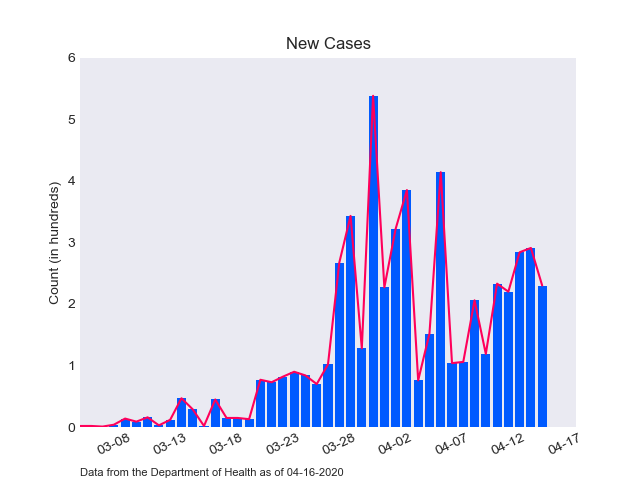

In [16]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

# Plots
ax.bar(df_number_of_cases.index, df_number_of_cases.new_cases / 100, width=0.8, color='#005aff') # 
ax.plot(df_number_of_cases.index, df_number_of_cases.new_cases / 100, color="#ff005a")

plt.xlim(pd.to_datetime('2020-03-05'), pd.to_datetime('2020-04-18'))
plt.ylim(0, 6)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.title('New Cases')
plt.xlabel(' ')
plt.ylabel('Count (in hundreds)')
plt.xticks(rotation=25)

ax.text(pd.to_datetime('2020-03-05'), -0.8, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/new_cases', dpi=300, bbox_inches='tight')

### Deaths and Recoveries

In [17]:
# Recoveries

df_number_of_recoveries = pd.DataFrame(df[df['RemovalType']=='Recovered'].DateRecover.value_counts())
df_number_of_recoveries.columns = ['new_recoveries']
df_number_of_recoveries.sort_index(inplace=True)
df_number_of_recoveries['total_recoveries'] = np.cumsum(df_number_of_recoveries.new_recoveries)
df_number_of_recoveries.head()

,new_recoveries,total_recoveries
2020-01-31,1,1
2020-02-08,1,2
2020-03-03,1,3
2020-03-06,1,4
2020-03-15,4,8


In [18]:
# Deaths

df_number_of_deaths = pd.DataFrame(df[df['RemovalType']=='Died'].DateDied.value_counts())
df_number_of_deaths.columns = ['new_deaths']
df_number_of_deaths.sort_index(inplace=True)
df_number_of_deaths['total_deaths'] = np.cumsum(df_number_of_deaths.new_deaths)
df_number_of_deaths.head()

,new_deaths,total_deaths
2020-02-01,1,1
2020-03-11,3,4
2020-03-12,3,7
2020-03-13,4,11
2020-03-14,4,15


<IPython.core.display.Javascript object>


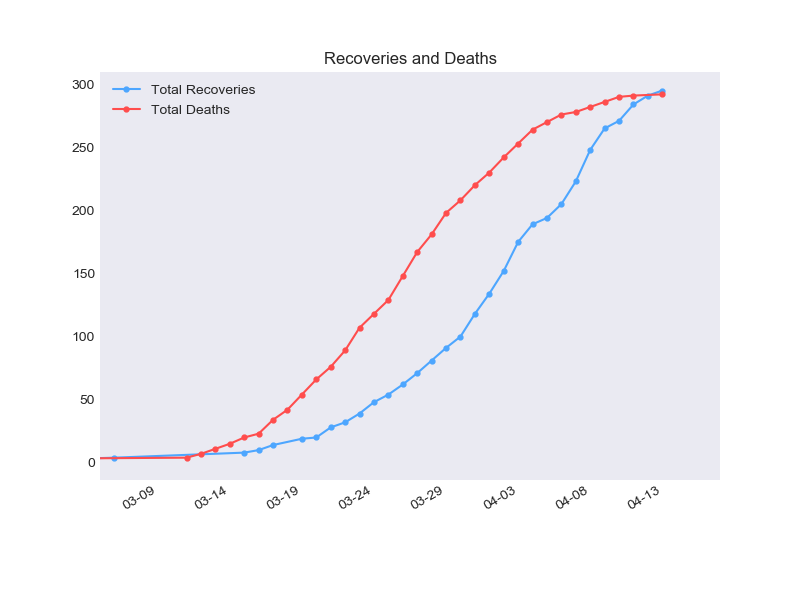

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
plt.title('Recoveries and Deaths')


df_number_of_recoveries['total_recoveries'].plot(ax=ax, marker='o', label='Total Recoveries', lw=1.5, color='#4da6ff', ms=3.5)
df_number_of_deaths['total_deaths'].plot(ax=ax, marker='o', label='Total Deaths', lw=1.5, color='#ff4d4d', ms=3.5)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.xlabel(' ')
plt.xlim(pd.to_datetime('2020-03-05'), pd.to_datetime('2020-04-17'))

plt.legend()

# Dont save yet, incomplete

### Exponential Plot

<IPython.core.display.Javascript object>


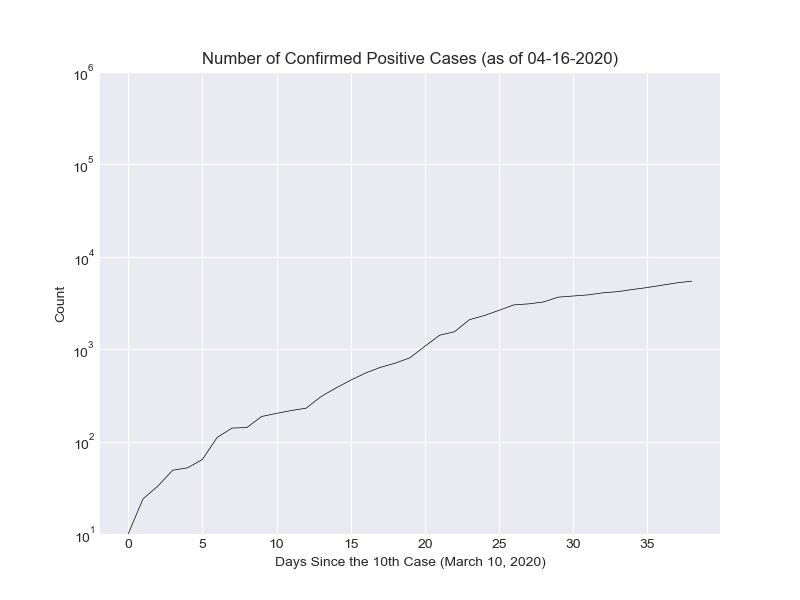

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

no_days_since_10th = np.array([i for i in range(0, len(df_number_of_cases['total_cases'][5:]))])
ax.plot(no_days_since_10th, df_number_of_cases['total_cases'][5:], 
        lw=0.5, color='k')

# Line that doubles everyday
#ax.plot(no_days_since_10th[:30], 1.2**no_days_since_10th[:30])

# Customization
plt.title('Number of Confirmed Positive Cases (as of {})'.format(time_stamp))
plt.xlabel('Days Since the 10th Case (March 10, 2020)')
plt.ylabel('Count')

ax.set_yscale('log')
plt.ylim((10^0, 10**6) )

plt.grid(True)
plt.savefig('images/exponential', dpi=300, bbox_inches='tight')

# Age Analysis

In [21]:
num_nan_ages = np.sum([pd.isna(i) for i in df.Age])
num_nan_ages

2

### Different bins

<IPython.core.display.Javascript object>


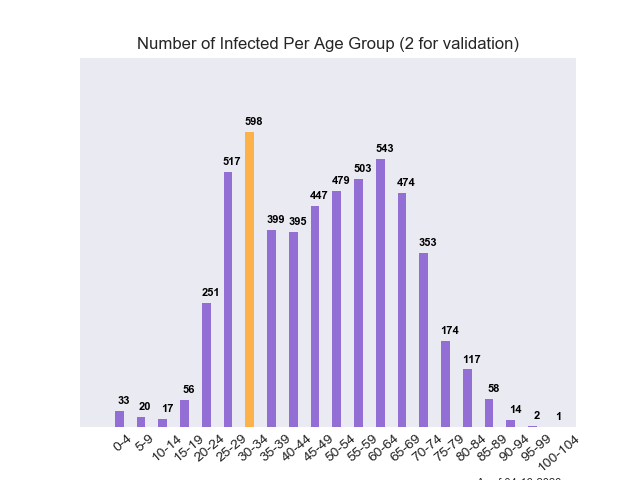

[Text(0, 0, '0-4'),
 Text(5, 0, '5-9'),
 Text(10, 0, '10-14'),
 Text(15, 0, '15-19'),
 Text(20, 0, '20-24'),
 Text(25, 0, '25-29'),
 Text(30, 0, '30-34'),
 Text(35, 0, '35-39'),
 Text(40, 0, '40-44'),
 Text(45, 0, '45-49'),
 Text(50, 0, '50-54'),
 Text(55, 0, '55-59'),
 Text(60, 0, '60-64'),
 Text(65, 0, '65-69'),
 Text(70, 0, '70-74'),
 Text(75, 0, '75-79'),
 Text(80, 0, '80-84'),
 Text(85, 0, '85-89'),
 Text(90, 0, '90-94'),
 Text(95, 0, '95-99'),
 Text(100, 0, '100-104')]

In [22]:
fig = plt.figure()

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')

ax = plt.subplot(111)

bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105])
n, bins, patches = ax.hist(df.Age, bins, histtype='bar', color='#936ED4',rwidth=0.8, width=2, align='left')
patches[np.argmax(n)].set_fc('#FCB249')

# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 105:
        break
    ax.text(bin_, n[index] + 20, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=8)
    
if num_nan_ages==0:
    ax.set_title('Number of Infected Per Age Group')
    
if num_nan_ages>0:
    ax.set_title('Number of Infected Per Age Group ({} for validation)'.format(num_nan_ages))
    
# xtick labels
plt.xticks(bins)
ax.set_xlim(-10,104)
ax.set_ylim(0,np.max(n)+150)
    
# Removing spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Removing yticks
ax.get_yaxis().set_visible(False)

# Removing ticks
ax.tick_params(axis=u'both', which=u'both',length=0)

# Time stamp
ax.text(81, -120, 'As of {}'.format(time_stamp), fontsize=8)


# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_xticklabels()])
new_labels = []
for i in range(0,len(labels)-1):
    new_labels.append(labels[i] + '-' + str(int(labels[i+1])-1))
    
ax.set_xticklabels(new_labels, rotation=40)

In [23]:
# Sanity check

np.sum(n) + num_nan_ages

5453.0

total cases

### Horizontal bar graph

<IPython.core.display.Javascript object>


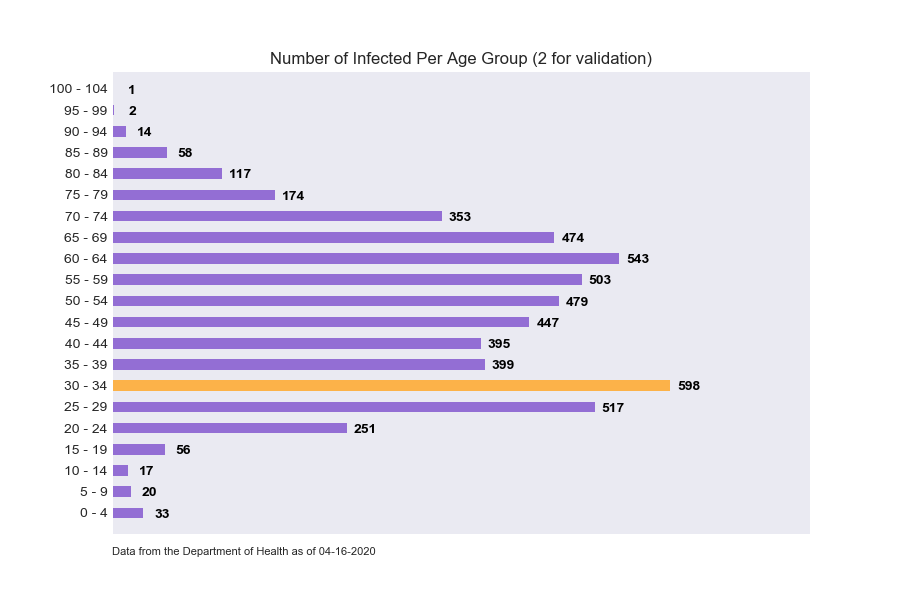

In [24]:
fig = plt.figure(figsize=(9,6))

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
ax = plt.subplot(111)

if num_nan_ages==0:
    ax.set_title('Number of Infected Per Age Group')
    
if num_nan_ages>0:
    ax.set_title('Number of Infected Per Age Group ({} for validation)'.format(num_nan_ages))


bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105])
n, bins, patches = ax.hist(df.Age, bins, histtype='bar', orientation="horizontal",
                           color='#936ED4', rwidth=0.5,  align='left')#,width=2 ,
patches[np.argmax(n)].set_fc('#FCB249')


# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 105:
        break
        
    ax.text(n[index] +20, bin_-0.4, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=10)
    
    
plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+150)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)

plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+150)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)

# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_yticklabels()])
new_labels = []
for i in range(0,len(labels)-1):
    new_labels.append(labels[i] + ' - ' + str(int(labels[i+1])-1))
    
ax.set_yticklabels(new_labels)

# Timestamp and source
ax.text(0, -10, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/num_infected', dpi=300, bbox_inches='tight')

### Deaths

<IPython.core.display.Javascript object>


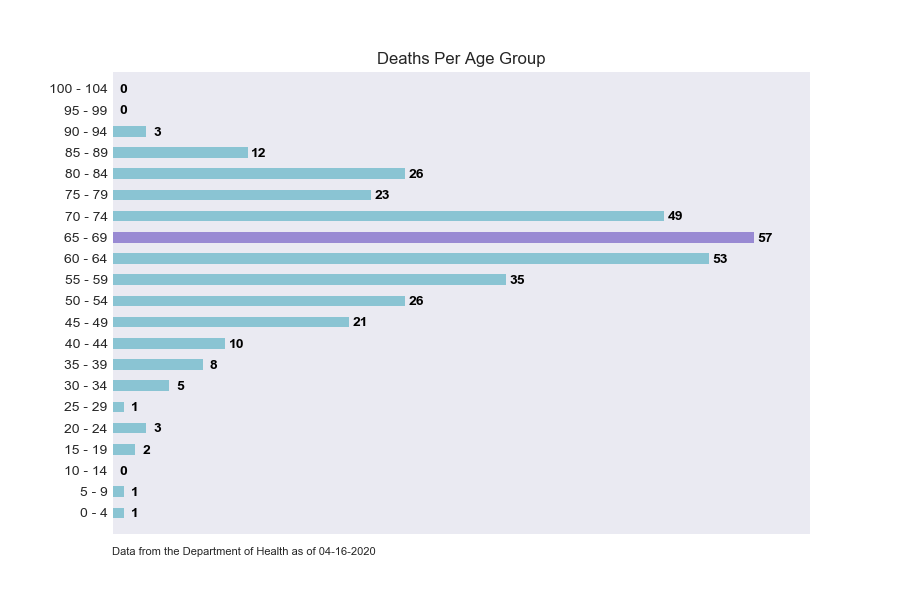

In [25]:
fig = plt.figure(figsize=(9,6))

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
ax = plt.subplot(111)

ax.set_title('Deaths Per Age Group')

bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105])
n, bins, patches = ax.hist(df[df.RemovalType=='Died'].Age, bins, histtype='bar', orientation="horizontal",
                           color='#8ac4d3', rwidth=0.5,  align='left')#,width=2 ,
patches[np.argmax(n)].set_fc('#998AD3')


# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 105:
        break
        
    ax.text(n[index]+1, bin_-0.3, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=10)
    
plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)

plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)


# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_yticklabels()])
new_labels = []
for i in range(0,len(labels)-1):
    new_labels.append(labels[i] + ' - ' + str(int(labels[i+1])-1))
    
ax.set_yticklabels(new_labels)

# Timestamp and source
ax.text(0, -10, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/death_age_gp', dpi=300, bbox_inches='tight')

In [26]:
np.sum(n)

336.0

deaths

### Recoveries

<IPython.core.display.Javascript object>


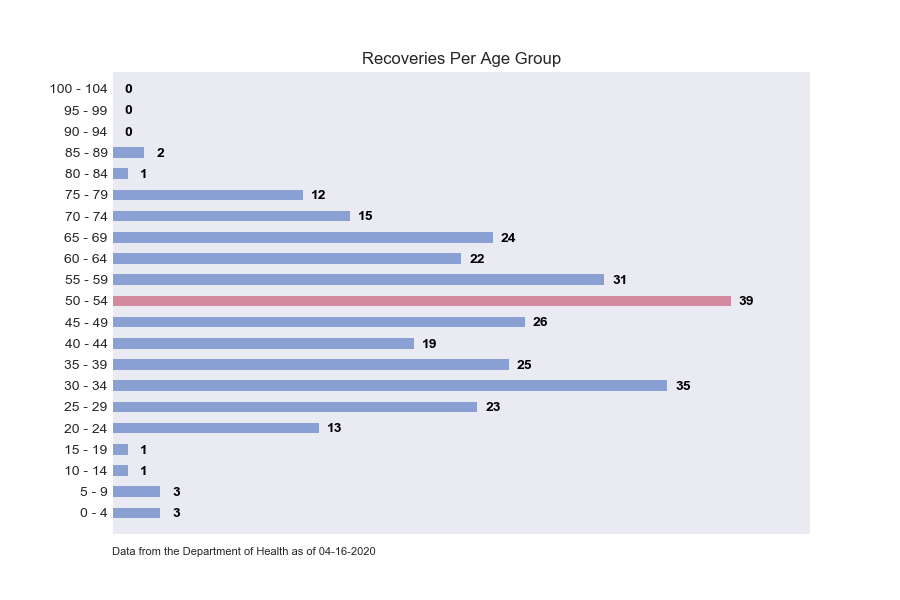

In [27]:
fig = plt.figure(figsize=(9,6))

plt.rcParams.update({'font.size': 10})
plt.style.use('seaborn-dark')
ax = plt.subplot(111)

ax.set_title('Recoveries Per Age Group')

bins = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105])
n, bins, patches = ax.hist(df[df.RemovalType=='Recovered'].Age, bins, histtype='bar', orientation="horizontal",
                           color='#8aa0d3', rwidth=0.5,  align='left')#,width=2 ,
patches[np.argmax(n)].set_fc('#d38aa0')


# label each bar with each count
for index, bin_ in enumerate(bins):
    if bin_== 105:
        break
        
    ax.text(n[index]+1, bin_-0.3, int(n[index]), 
            color='black', fontweight='bold',
            horizontalalignment='center', verticalalignment='center', fontsize=10)
    
plt.yticks(bins)
ax.set_ylim(-5,89)
ax.set_xlim(0,np.max(n)+1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)

plt.yticks(bins)
ax.set_ylim(-5,104)
ax.set_xlim(0,np.max(n)+5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Removing yticks
ax.get_xaxis().set_visible(False)


# Draw the plot first then adjust the ticklabels
fig.canvas.draw()
labels = np.array([item.get_text() for item in ax.get_yticklabels()])
new_labels = []
for i in range(0,len(labels)-1):
    new_labels.append(labels[i] + ' - ' + str(int(labels[i+1])-1))
    
ax.set_yticklabels(new_labels)

# Timestamp and source
ax.text(0, -10, 'Data from the Department of Health as of {}'.format(time_stamp), fontsize=8)

plt.savefig('images/recoveries_age_gp', dpi=300, bbox_inches='tight')

In [28]:
np.sum(n)

295.0

number of recoveries

# Mapping the provinces with cases

In [29]:
df_regions = pd.DataFrame(df.RegionRes[pd.notnull(df.RegionRes)].value_counts())
df_regions.columns = ['counts']
df_regions['Province'] = df_regions.index

# Repositioning the columns 
df_regions = df_regions[['Province', 'counts']]

# Changing the indices to a list of numbers
df_regions.index = [i for i in range(0, len(df_regions))]
df_regions[:10]

,Province,counts
0,Metropolitan Manila,3698
1,Rizal,301
2,Laguna,219
3,Cavite,184
4,Bulacan,99
5,Davao del Sur,81
6,Batangas,78
7,Pampanga,54
8,Nueva Ecija,45
9,Cebu,42


In [30]:
# Sanity check

np.sum(df_regions.counts)

5176

In [33]:
# Getting the number of for validation cells

num_prov_TBA = len(df) - np.sum(df_regions.counts)
num_prov_TBA

277

In [31]:
# Loading the shapefile
phl1 = shapefile.Reader("Shapefiles/gadm36_PHL_1") 

<IPython.core.display.Javascript object>


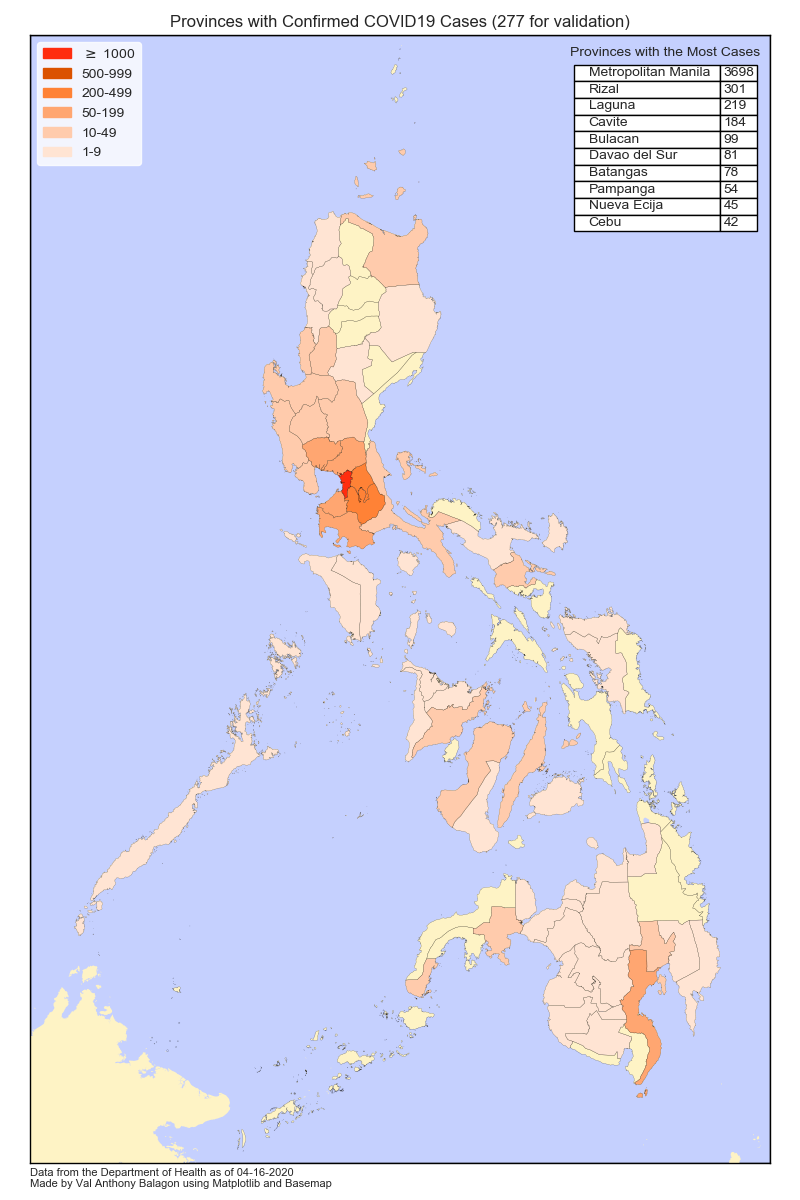

C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [63]:
fig, ax = plt.subplots(figsize=(8,12))

if num_prov_TBA == 0:
    plt.title('Provinces with Confirmed COVID19 Cases')
if num_prov_TBA > 0 :
    plt.title('Provinces with Confirmed COVID19 Cases ({} for validation)'.format(num_prov_TBA))

m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution='f',
                projection='tmerc', lat_0 = 14, lon_0 = 120) 

# Reading the shapefile
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = False)

# Coloring the province
def province_color(condition):
    patches=[]
    for info, shape in zip(m.shf_info, m.shf):
        for i in list(df_regions[condition].Province):
            if info['NAME_1'] == i:
                patches.append( Polygon(np.array(shape), True) )
    return patches

# 1-10
ax.add_collection(PatchCollection(province_color((df_regions.counts<10) & (df_regions.counts>=1)), 
                                  facecolor='#ffe4d3', linewidths=0.1, zorder=2))
# 10-50
ax.add_collection(PatchCollection(province_color((df_regions.counts<50) & (df_regions.counts>=10)), 
                                  facecolor='#ffcbac', linewidths=0.1, zorder=2))
# 50-200
ax.add_collection(PatchCollection(province_color((df_regions.counts<200) & (df_regions.counts>=50)), 
                                  facecolor='#ffa671', linewidths=0.1, zorder=2))
# 200-500
ax.add_collection(PatchCollection(province_color((df_regions.counts<500) & (df_regions.counts>=200)), 
                                  facecolor='#ff8236', linewidths=0.1, zorder=2))
# 500-1000
ax.add_collection(PatchCollection(province_color((df_regions.counts<1000) & (df_regions.counts>=500)), 
                                  facecolor='#db5200', linewidths=0.1, zorder=2))
# greater than 1000
ax.add_collection(PatchCollection(province_color((df_regions.counts>=1000)), 
                                  facecolor='#ff2d0f', linewidths=0.1, zorder=2))

# Legend
more_1000 = mpatches.Patch(color='#ff2d0f', label=r'$\geq$ 1000')
less_1000 = mpatches.Patch(color='#db5200', label=r'500-999')
less_500 = mpatches.Patch(color='#ff8236', label=r'200-499')
less_200 = mpatches.Patch(color='#ffa671', label=r'50-199')
less_50 = mpatches.Patch(color='#ffcbac', label=r'10-49')
less_10 = mpatches.Patch(color='#ffe4d3', label=r'1-9')
leg = plt.legend(loc=2, handles=[less_10, less_50, less_200, less_500, less_1000, more_1000][::-1], frameon=True)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')


# Make sure that the lakes do not get filled
m.drawmapboundary(fill_color='#c5d0fe')
m.fillcontinents(color='#FEF3C5', lake_color='#c5d0fe')
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = True)

# Top provinces
## Making another axis to make an inset
left, bottom, width, height = [0.75, 0.75, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_title('Provinces with the Most Cases', fontsize=10,x=0.405, y=.98)

## Making the table
top_10_prov_ls = np.array((df_regions.Province[:10]))[np.newaxis].T
top_10_prov_count = np.array((df_regions.counts[:10]))[np.newaxis].T
table = ax2.table(cellText=np.hstack((top_10_prov_ls, top_10_prov_count)),
                  colWidths = [0.2]*100,
                  loc='upper right',
                  fontsize=10,
                  cellLoc='left',
                  edges='closed')
table.auto_set_column_width(col=list(range(len(df_regions))))
ax2.axis("off")
ax2.axis('tight')

ax.text(0, -40000, 'Data from the Department of Health as of {}\nMade by Val Anthony Balagon using Matplotlib and Basemap'.format(time_stamp), fontsize=8)
fig.tight_layout()

In [64]:
plt.savefig('images/provinces_w_cases_{}'.format(time_stamp), dpi=800, bbox_inches='tight')

In [43]:
len(df_regions)

55

 out of 81 provinces have at least 1 confirmed positive COVID-19 case

### Locations of each case

In [44]:
df_locs = df[(df.ProvCityRes.notnull()) & (df.RegionRes.notnull())][['CaseCode', 'RegionRes', 'ProvCityRes']].copy()

# Replacing Metropolitan Manila to Metro Manila
df_locs.RegionRes.replace(to_replace='Metropolitan Manila', value='Metro Manila', inplace=True)

# Removes parenthesis in cities 
def remove_parenthesis(text):
    if '(' in text:
        return re.findall('(.+) \(.+\)', text)[0]
    else:
        return text
# Removes "City of"
def remove_cityof(txt):
    if 'City of' in txt:
        return re.findall('City of (.+)', txt)[0]
    else:
        return txt
    
df_locs.ProvCityRes = df_locs.ProvCityRes.apply(remove_parenthesis).apply(remove_cityof)

# Combining the city and province string for geocoding
df_locs['comp_address'] = [df_locs.iloc[i].ProvCityRes + ', ' + df_locs.iloc[i].RegionRes for i in range(0, len(df_locs))]

df_locs = pd.DataFrame(df_locs.comp_address.value_counts())
df_locs.columns = ['counts']
df_locs['com_address'] = df_locs.index
df_locs.index = [i for i in range(0, len(df_locs))]
df_locs = df_locs[['com_address', 'counts']]
df_locs.head()

,com_address,counts
0,"Quezon City, Metro Manila",992
1,"Manila, Metro Manila",470
2,"Parañaque, Metro Manila",328
3,"Makati, Metro Manila",322
4,"Mandaluyong, Metro Manila",276


In [46]:
# Geocoding 
coords = []
for i in df_locs.com_address:
    location = do_geocode(i)
    coords.append((location.latitude, location.longitude))

Quezon City, Metro Manila, Philippines
Manila, Metro Manila, Philippines
Parañaque, Metro Manila, Philippines
Makati, Makati 1st District, Makati, Metro Manila, 1226, Philippines
Mandaluyong, Metro Manila, 1551, Philippines
Pasig, Metro Manila, Philippines
Taguig, Metro Manila, Philippines
San Juan, 1st District, San Juan, Metro Manila, 1500, Philippines
Pasay, Metro Manila, Philippines
Caloocan City, 134, C. Namie, Barangay 37, Marulas, 2nd District, Caloocan, Metro Manila, 002, Philippines
Las Piñas, 1st District, Las Piñas, Metro Manila, Philippines
Muntinlupa, Metro Manila, Philippines
Marikina, Metro Manila, Philippines
Antipolo, Rizal, Calabarzon, 1870, Philippines
Davao del Sur, Davao Region, Philippines
Cainta, Rizal, Calabarzon, Philippines
Bacoor, Cavite, Calabarzon, 4102, Philippines
Valenzuela, Metro Manila, Philippines
San Pedro, Laguna, Calabarzon, 4023, Philippines
Taytay, Rizal, Calabarzon, Philippines
Imus, Cavite, Calabarzon, 4103, Philippines
Cebu City, Cebu, Central

Urdaneta, Pangasinan, Ilocos, 2428, Philippines
Baras, Rizal, Calabarzon, 1970, Philippines
San Jose, Occidental Mindoro, Mimaropa, Philippines
Agoo, La Union, Philippines
Pulilan, Bulacan, Central Luzon, 3005, Philippines
Capas, Tarlac, Central Luzon, Philippines
Alaminos, Laguna, Calabarzon, 4001, Philippines
Jimalalud, Negros Oriental, Central Visayas, Philippines
Panabo, Davao del Norte, Davao Region, 8105, Philippines
Candelaria, Zambales, Central Luzon, 2212, Philippines
Santa Ana, Pampanga, Central Luzon, 2022, Philippines
Mendez, Cavite, Calabarzon, 4121, Philippines
Calumpit, Bulacan, Central Luzon, 3003, Philippines
San Fernando, La Union, Ilocos, Philippines
Mandaue City, United Nations Avenue, Dona Rosario Village, Sangi, Mandaue, Cebu, Central Visayas, 6014, Philippines
San Ildefonso, Bulacan, Central Luzon, 3010, Philippines
Miagao, Municipality of Miagao, Iloilo, Western Visayas, 5023, Philippines
Bauan, Batangas, Calabarzon, 4201, Philippines
Daraga, Albay, Bicol, 4501,

Rosario, Batangas, Calabarzon, 4225, Philippines
Bacacay, Albay, Bicol, 4509, Philippines
Lasam, Cagayan, Cagayan Valley, Philippines
Dumalinao, Zamboanga del Sur, Zamboanga Peninsula, Philippines
Zaragoza, Nueva Ecija, Central Luzon, 3110, Philippines
San Antonio, Zambales, Central Luzon, 2206, Philippines
Concepcion, Tarlac, Central Luzon, 2316, Philippines


In [47]:
df_locs['coordinates'] = coords #latitude, longitude
df_locs.head()

,com_address,counts,coordinates
0,"Quezon City, Metro Manila",992,"(14.6509905, 121.0486155)"
1,"Manila, Metro Manila",470,"(14.5906216, 120.9799696)"
2,"Parañaque, Metro Manila",328,"(14.5007016, 120.9915488)"
3,"Makati, Metro Manila",322,"(14.5568853, 121.023532)"
4,"Mandaluyong, Metro Manila",276,"(14.5777807, 121.0332295)"


### Map

In [55]:
# Number of tba

num_TBA_city = len(df) - np.sum(df_locs.counts)

In [48]:
lats = [df_locs.coordinates.iloc[i][0] for i in range(0, len(df_locs))]
longs = [df_locs.coordinates.iloc[i][1] for i in range(0, len(df_locs))]

<IPython.core.display.Javascript object>


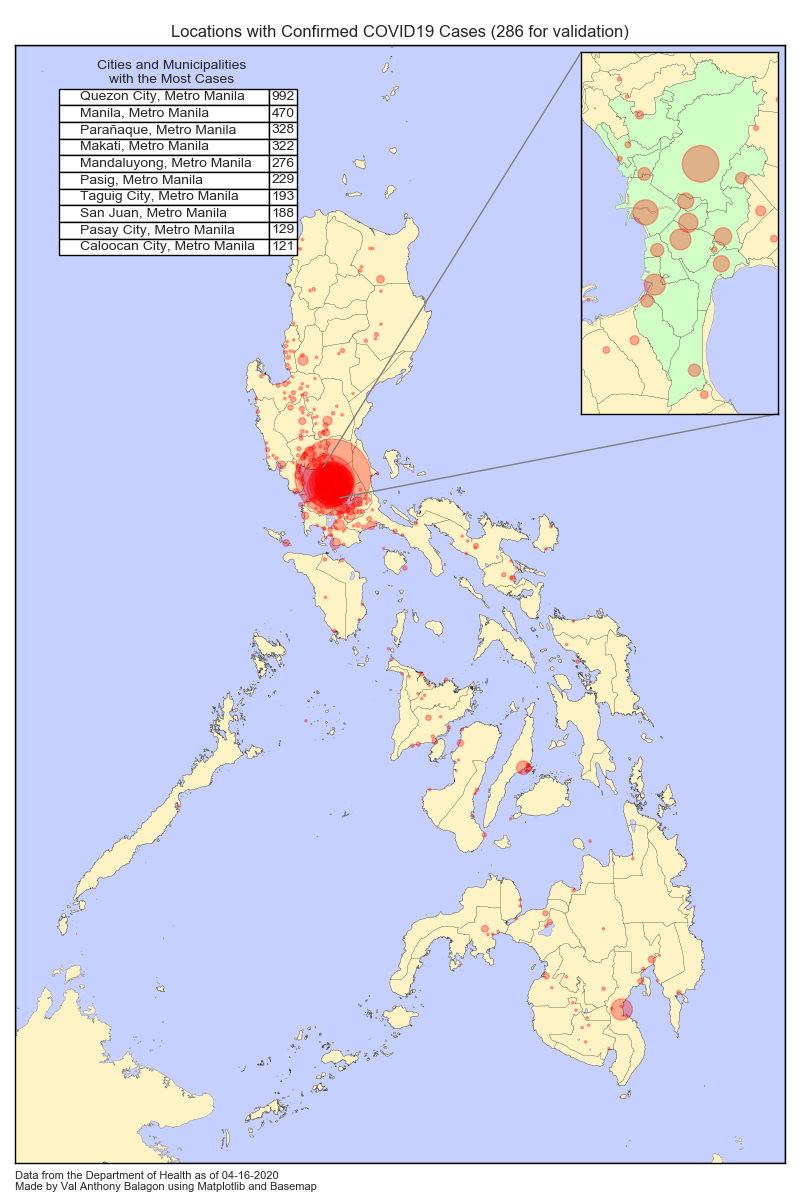

C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:43: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 

Text(116.3, 4, 'Data from the Department of Health as of 04-16-2020\nMade by Val Anthony Balagon using Matplotlib and Basemap')

In [56]:
fig, ax = plt.subplots(figsize=(8,12))

if num_TBA_city == 0:
    plt.title('Locations with Confirmed COVID19 Cases')
if num_TBA_city > 0:
    plt.title('Locations with Confirmed COVID19 Cases ({} for validation)'.format(num_TBA_city))

qual = 'f'
m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.8, urcrnrlat=21.1, resolution=qual, 
            lat_0 = 14, lon_0 = 120) #, projection='tmerc' 

m.drawmapboundary(fill_color='#c5d0fe')
m.fillcontinents(color='#FEF3C5', lake_color='#c5d0fe')
m.drawcoastlines(linewidth=0.1)
m.readshapefile('Shapefiles/gadm36_PHL_1','shf', linewidth=0.1, drawbounds = True)

# Scatter Plot
x,y = m(longs, lats)
ax.scatter(x,y, c='red', alpha=.3, s=df_locs.counts * 3, zorder=10)

# Table
left, bottom, width, height = [0.175, 0.73, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_title('Cities and Municipalities\nwith the Most Cases', fontsize=10,x=0.2, y=.97)

## Making the table
top_10_cities_ls = np.array((df_locs.com_address[:10]))[np.newaxis].T
top_10_cities_count = np.array((df_locs.counts[:10]))[np.newaxis].T
table = ax2.table(cellText=np.hstack((top_10_cities_ls, top_10_cities_count)),
                  colWidths = [0.2]*100,
                  loc='upper right',
                  fontsize=10,
                  cellLoc='left',
                  edges='closed')
table.auto_set_column_width(col=list(range(len(df_locs))))
ax2.axis("off")
ax2.axis('tight')


# Map inset of Metro Manila
axins = zoomed_inset_axes(ax, 12, loc=1)
m2 = Basemap(llcrnrlon=120.9, llcrnrlat=14.34, urcrnrlon=121.145, urcrnrlat=14.79, 
             resolution=qual, lat_0 = 14.34, lon_0 = 121, ax=axins) 
m.drawmapboundary(fill_color='#c5d0fe')
m.fillcontinents(color='#FEF3C5', lake_color='#c5d0fe')
m.drawcoastlines(linewidth=0.1)
m2.readshapefile('Shapefiles/gadm36_PHL_2', 'shf', linewidth=0.1,  drawbounds=False)

# Highlight Manila
patches = []
for info, shape in zip(m2.shf_info, m2.shf):
    if info['NAME_1'] == 'Metropolitan Manila':
        patches.append(Polygon(np.array(shape), True))        
axins.add_collection(PatchCollection(patches, facecolor='#d0fec5', linewidths=0.1, zorder=2))
m2.readshapefile('Shapefiles/gadm36_PHL_2', 'shf', linewidth=0.1,  drawbounds=True)

x_ins, y_ins = m(longs, lats)
axins.scatter(x_ins, y_ins, c='red', alpha=.3, s=df_locs.counts * 0.7, zorder=10)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

fig.tight_layout()
ax.text(116.3, 4, 'Data from the Department of Health as of {}\nMade by Val Anthony Balagon using Matplotlib and Basemap'.format(time_stamp), fontsize=8)

In [57]:
plt.savefig('images/map_of_cases_{}'.format(time_stamp), dpi=800, bbox_inches='tight')

### Testing Sites

In [58]:
df_testing_sites = pd.read_csv('C:/Users/tonba/Desktop/Masters Stuff/Projects/COVID19/COVID19_PH_Project/Raw Data/laboratories.csv')
df_testing_sites[:16] # The only ones who can test

,health_facility,stage,testing_capacity
0,Research Institute for Tropical Medicine,5,900.0
1,Baguio General Hospital and Medical Center,5,150.0
2,San Lazaro Hospital,5,100.0
3,Vicente Sotto Memorial Medical Center,5,240.0
4,Southern Philippines Medical Center,5,100.0
5,UP National Institutes of Health,5,80.0
6,Lung Center of the Philippines,5,100.0
7,Western Visayas Medical Center,5,80.0
8,Bicol Public Health Laboratory,5,NaN
9,St. Luke's Medical Center - Quezon City,5,NaN


### Addresses not known

TB Reference Center CHD

Metro Pacific Hospital Holdings, Inc. - Muntinlupa

In [59]:
# Removing

df_testing_sites.drop(df_testing_sites.index[[47,58]], inplace=True)
df_testing_sites.index = [i for i in range(0, len(df_testing_sites))]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(df_testing_sites)

### Cleaning

In [60]:
# UP National Institute of Health -> UP Manila
df_testing_sites.replace(to_replace ="UP National Institutes of Health", value ="UP Manila", inplace=True) 

df_testing_sites.replace(to_replace ="Tarlac Provincial Lab", value ="Tarlac Provincial Hospital", inplace=True) 

df_testing_sites.replace(to_replace ="New World Diagnostics", value ="New World Diagnostics Quezon City", inplace=True) 

df_testing_sites.replace(to_replace ="Philippine Red Cross", 
                         value ="Philippine Red Cross National Headquarters", inplace=True) 

df_testing_sites.replace(to_replace ="Dr. Jorge P. Royeca City Hospital", value ="Dr. Jorge P. Royeca Hospital", inplace=True) 

df_testing_sites.replace(to_replace ="Victoriano Luna Hospital", value ="Victoriano Luna Medical Center", inplace=True) 

df_testing_sites.replace(to_replace ="Bicol Public Health Laboratory", 
           value ="Bicol Regional Diagnostic and Reference Laboratory", inplace=True) 

# St. Luke's Medical Center Global City
df_testing_sites.replace(to_replace ="St. Luke's Medical Center - BGC", value ="St. Luke's Medical Center Global City", inplace=True) 

df_testing_sites.replace(to_replace ="Philippine Genome Center, UP Diliman", 
           value ="Philippine Genome Center", inplace=True) 

df_testing_sites.replace(to_replace ="Laguna Provincial Hospital", 
           value ="Laguna Medical Center", inplace=True) 

# The Medical City
df_testing_sites.replace(to_replace ="The Medical City", value ="The Medical City Ortigas", inplace=True) 

# Molecular Diagnostics Laboratory -> High Pointe Medical Hub
df_testing_sites.replace(to_replace ="Detoxicare Molecular Diagnostics Laboratory", value ="High Pointe Medical Hub", inplace=True) 

# Governor Celestino Gallares Memorial Medical Center -> Memorial Hospital
df_testing_sites.replace(to_replace ="Governor Celestino Gallares Memorial Medical Center", 
           value ="Governor Celestino Gallares Memorial Hospital", inplace=True) 

# and Medical Center
df_testing_sites.replace(to_replace ="Chinese General Hospital", 
           value ="Chinese General Hospital and Medical Center", inplace=True) 

# Mariano Marcos Hospital and Medical Center
df_testing_sites.replace(to_replace ="Mariano Marcos Hospital and Medical Center", 
           value ="Mariano Marcos Memorial Hospital and Medical Center", inplace=True) 

# De La Salle Medical and Health Sciences Institute - Center for Tuberculosis Laboratory
df_testing_sites.replace(to_replace ="De La Salle Medical and Health Sciences Institute - Center for Tuberculosis Laboratory", 
           value ="De La Salle Medical and Health Sciences Institute", inplace=True) 

df_testing_sites.replace(to_replace ="Zamboanga City Medical Center - Clinical Laboratory", 
           value ="Zamboanga City Medical Center", inplace=True) 

df_testing_sites.replace(to_replace ="Department of Agriculture Field Office - Zamboanga", 
           value ="Department of Agriculture (RSO-Zamboanga City)", inplace=True) 

df_testing_sites.replace(to_replace ="Philippine Genome Center, UP Mindanao", 
           value ="University of the Philippines Mindanao", inplace=True) 

df_testing_sites.replace(to_replace ="San Pablo College and Medical Center", 
           value ="San Pablo Colleges Medical Center", inplace=True) 

df_testing_sites.replace(to_replace ="Kaiser Medical Center, Inc.", 
           value ="Kaiser Medical Center, Philippines", inplace=True) 

df_testing_sites.replace(to_replace ="Green City Medical Center", 
           value ="GreenCity Medical Center", inplace=True) 

df_testing_sites.replace(to_replace ="Divine Word Hospital", 
           value ="Divine Word Hospital, Bulacan", inplace=True) 

### Geocoding

In [61]:
df_testing_sites['coordinates'] = df_testing_sites['health_facility'].apply(do_geocode).apply(lambda x: (x.latitude, x.longitude))

Research Institute for Tropical Medicine, Corporate Woods Avenue, Alabang, Muntinlupa, Metro Manila, 1781, Philippines
Baguio General Hospital & Medical Center, Kennon Road, Poliwes, Baguio City, Benguet, Cordillera Administrative Region, 2600, Philippines
San Lazaro Hospital, Quiricada Street, Barangay 325, Santa Cruz, Third District, Metro Manila, 1003, Philippines
Vicente Sotto Memorial Medical Center, C. Rodriguez, Sacred Village, Sambag II, Cebu City, Cebu, Central Visayas, 6000, Philippines
Southern Philippines Medical Center, J. P. Laurel Avenue, Jereza Subdivision, Vita Residences, Davao City, Davao Region, 8000, Philippines
UP Manila, Maria Y. Orosa, Barangay 670, Ermita, Fifth District, Metro Manila, 1000, Philippines
Lung Center of the Philippines, Quezon Avenue, East Triangle, Pinyahan, Quezon City, 4th District, Metro Manila, 1100, Philippines
Western Visayas Medical Center, Q. Abeto St., Mandurriao, Iloilo City, Iloilo, Western Visayas, 5000, Philippines
Bicol Regional Di

GreenCity Medical Center, Jose Abad Santos Avenue, Gems Ville Subdivision Phase 2, Dolores Heights Subdivision, San Fernando, Pampanga, Central Luzon, 20, Philippines
Tarlac Provincial Hospital, West Fairlane, Fairlane Subd., Camp General Servillano S. Aquino, Tarlac City, Tarlac, Central Luzon, 2300, Philippines
Zamboanga del Sur Medical Center, Dao Road, Lasaran, Purok Bahada, Dao, Zamboanga del Sur, Zamboanga Peninsula, 7016, Philippines
New World Diagnostics, D. Tuazon, Maharlika, Santa Mesa Heights, 1st District, Metro Manila, 1115, Philippines
Amai Pakpak Medical Center, Amai Pakpak Avenue, Marawi, Lanao del Sur, Bangsamoro Autonomous Region in Muslim Mindanao, 09700, Philippines
General Santos City Hospital, Eusebio Fernandez Street, Naval, General Santos, South Cotabato, Soccsksargen, 9500, Philippines
Pasig Doctors Medical Center, Tramo, Cruz-Robles, Manggahan, Pasig, Metro Manila, 1611, Philippines
ARC Hospitals, Mactan Circumferential Road, White Sands Subdivision, Basak, Ag

<IPython.core.display.Javascript object>


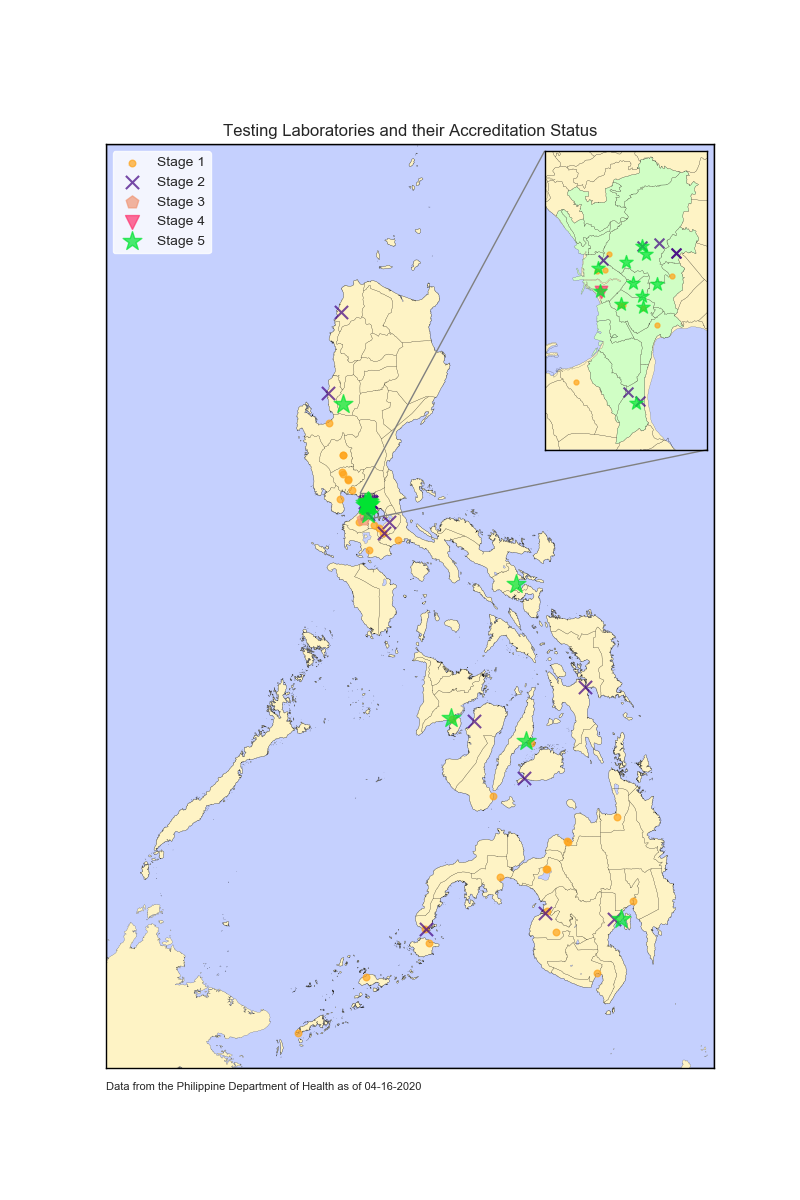

C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tonba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\tonba\AppData\Local\Con

In [66]:
import matplotlib

fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)

reso = 'f'
plt.title('Testing Laboratories and their Accreditation Status')
m = Basemap(llcrnrlon=116.3,llcrnrlat=4.4, urcrnrlon=127.3, urcrnrlat=21.1, resolution=reso, 
            lat_0 = 14, lon_0 = 120, ax=ax) 

# Design
m.drawmapboundary(fill_color='#c5d0fe')
m.fillcontinents(color='#FEF3C5', lake_color='#c5d0fe')
m.drawcoastlines(linewidth=0.1)

# Reading the shapefile
m.readshapefile('C:/Users/tonba/Desktop/Masters Stuff/Projects/COVID19/COVID19_PH_Project/Shapefiles/gadm36_PHL_1',
                'shf', linewidth=0.1, drawbounds = True)

# Conversion of lats longs wrt to the projection
def testing_scatter(map_, axis_, n, marker, label, size, color):
    lats = [i[0] for i in df_testing_sites[df_testing_sites.stage == n].coordinates]
    longs = [i[1] for i in df_testing_sites[df_testing_sites.stage == n].coordinates]
    xpt, ypt = map_(longs, lats)
    return axis_.scatter(xpt, ypt, c=color, zorder=10, marker=marker, alpha=.7, s=size, label=label)

testing_scatter(m, ax, 1, '.', 'Stage 1', 90, color='#ffa41b')
testing_scatter(m, ax, 2, 'x', 'Stage 2', 90, color='#400082')
testing_scatter(m, ax, 3, 'p', 'Stage 3', 90, color='#f09675')
testing_scatter(m, ax, 4, 'v', 'Stage 4', 100, color='#fe346e')
testing_scatter(m, ax, 5, '*', 'Stage 5', 200, color='#01e432')
leg = ax.legend(loc=2, frameon=True)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('white')

# Map inset of Metro Manila
axins = zoomed_inset_axes(m.ax, 12, loc=1)#bbox_to_anchor=(700,1020)
m2 = Basemap(llcrnrlon=120.9, llcrnrlat=14.34, urcrnrlon=121.145, urcrnrlat=14.79, 
             resolution=reso, lat_0 = 14.34, lon_0 = 121, ax=axins) 
m2.drawmapboundary(fill_color='#c5d0fe')
m2.fillcontinents(color='#FEF3C5', lake_color='#c5d0fe')
m2.drawcoastlines(linewidth=0.1)

# Reading the provincial shapefile
m2.readshapefile('Shapefiles/gadm36_PHL_2',
                'shf', linewidth=0.1,  drawbounds=False)
# Highlight Manila
patches = []
for info, shape in zip(m2.shf_info, m2.shf):
    if info['NAME_1'] == 'Metropolitan Manila':
        patches.append(Polygon(np.array(shape), True))        
axins.add_collection(PatchCollection(patches, facecolor='#d0fec5', linewidths=0.1, zorder=2))

# Drawing the shapefile
m2.readshapefile('Shapefiles/gadm36_PHL_2',
                'shf', linewidth=0.1, drawbounds = True)

# Plotting
testing_scatter(m2, axins, 1, '.', 'Stage 1', 50, color='#ffa41b')#Self-Assessment
testing_scatter(m2, axins, 2, 'x', 'Stage 2', 50, color='#400082')#Validation
testing_scatter(m2, axins, 3, 'p', 'Stage 3', 50, color='#f09675')#Personnel Training
testing_scatter(m2, axins, 4, 'v', 'Stage 4', 80, color='#fe346e')#Proficiency Testing
testing_scatter(m2, axins, 5, '*', 'Stage 5', 100, color='#01e432')#Fullscale Implementation

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.text(116.3, 4, 'Data from the Philippine Department of Health as of {}'.format(time_stamp), fontsize=8)
fig.savefig('images/locs_of_testing_sites_{}'.format(time_stamp), dpi=800, bbox_inches='tight')#

### Folium Interactive

In [67]:
m = folium.Map(location=[np.mean([i[0] for i in df_testing_sites.coordinates]), np.mean([i[1] for i in df_testing_sites.coordinates])], 
               tiles='https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
                attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>', 
               zoom_start=5.4)
mc = MarkerCluster()

def mapper(stage,color,icon='default'):
    # Getting the coordinates of each facility
    coords = [i for i in df_testing_sites[df_testing_sites.stage==stage].copy().coordinates]
    
    # Name of each facility with its status
    facilities = [i + '\nStage: {}'.format(str(stage)) for i in np.array(df_testing_sites[df_testing_sites.stage==stage].copy().health_facility)]
    
    #np.array(df_testing_sites[df_testing_sites.stage==stage].copy().health_facility)
    for coord, facility in zip(coords, facilities):
        folium.Marker(coord, radius=6, popup=facility, icon=folium.Icon(color=color,icon=icon)).add_to(mc)

# Stage 1
mapper(1, 'orange')

# Stage 2
mapper(2, 'blue')

# Stage 3
mapper(3, 'purple')

# Stage 4
mapper(4, 'green')

# Stage 5
mapper(5, 'red', 'star')


# Legend

m.add_child(mc)
m

In [68]:
m.save('images/labs.html')

# Comparison with other countries

# Archived

In [ ]:
# Reading the excel file

# excel = pd.ExcelFile('Raw Data/doh_data_drop_04-14-2020.xlsx')  
# df = pd.read_excel(excel, 'Case Information')
# df.head()